In [ ]:
#To run the code just run all the cells in the same sequence as they appear, or just click on 'Run' in the menu and click 'run all'
!pip install transformers datasets evaluate accelerate

In [ ]:
!pip install py7zr

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Exploratory Data Analysis

In [8]:
#using datasets library to load the samsum corpus
from datasets import load_dataset
dataset = load_dataset("samsum")
dataset

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [5]:
#splitting the data into test, train and validation
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

In [6]:
#Exploring the features of the dataset splits
print(f"Train Set:\n{train_ds}\nFeatures of Train Set:{train_ds.features}\n\n")
print(f"Test Set:\n{test_ds}\nFeatures of Test Set:{test_ds.features}\n\n")
print(f"Validation Set:\n{val_ds}\nFeatures of Validation Set:{val_ds.features}\n\n")

Train Set:
Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 14732
})
Features of Train Set:{'id': Value(dtype='string', id=None), 'dialogue': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None)}


Test Set:
Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 819
})
Features of Test Set:{'id': Value(dtype='string', id=None), 'dialogue': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None)}


Validation Set:
Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 818
})
Features of Validation Set:{'id': Value(dtype='string', id=None), 'dialogue': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None)}




In [7]:
#Converting the dataset into pandas DataFrame for better visualization
import pandas as pd
dataset.set_format(type="pandas")
df_train = dataset['train'][:]
df_train.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


In [8]:

df_train_dialouges = pd.DataFrame(df_train['dialogue'])
df_train_summaries = pd.DataFrame(df_train['summary'])


In [9]:
print('Descriptive analysis of dialouges in the Train Set:')
df_train_dialouges.describe()

Descriptive analysis of dialouges in the Train Set:


,dialogue
count,14732
unique,14265
top,"Jimmy: Hey, guess what? My car's completely ka..."
freq,4


In [10]:
print('Descriptive analysis of summaries in the Train Set:')
df_train_summaries.describe()

Descriptive analysis of summaries in the Train Set:


,summary
count,14732
unique,14730
top,Seth's pet Oreo that he got when he was 10 is ...
freq,2


In [11]:
#Creating a dataset with new features that indicate the length of dialogues and summaries in order to plot histogram later
def compute_length(dataset):
    return {'dialogue_length': [len(s.split()) for s in dataset['dialogue']],
           'summary_length': [len(s.split()) for s in dataset['summary']]}

ds_with_stats = dataset.map(compute_length)
ds_with_stats

  0%|          | 0/14732 [00:00<?, ?ex/s]

  0%|          | 0/819 [00:00<?, ?ex/s]

  0%|          | 0/818 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'dialogue_length', 'summary_length'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'dialogue_length', 'summary_length'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'dialogue_length', 'summary_length'],
        num_rows: 818
    })
})

In [12]:
ds_with_stats.set_format(type="pandas")

df_train = ds_with_stats['train'][:]
df_train.head()

,id,dialogue,summary,dialogue_length,summary_length
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,[16],[9]
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,[18],[10]
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,[98],[14]
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,[26],[18]
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...",[179],[27]


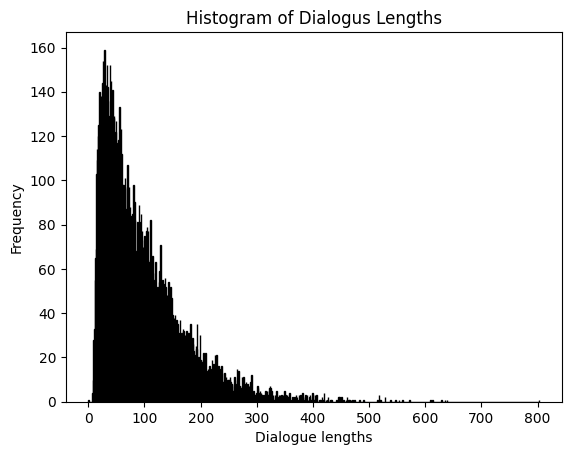

In [13]:
#Frequency distribution of the lengths of dialogs in the train set
import matplotlib.pyplot as plt

plt.hist(df_train['dialogue_length'].apply(lambda x: x[0]), bins=range(min(df_train['dialogue_length'].apply(lambda x: x[0])), max(df_train['dialogue_length'].apply(lambda x: x[0])) + 1), edgecolor='black')
plt.title("Histogram of Dialogus Lengths")
plt.xlabel("Dialogue lengths")
plt.ylabel("Frequency")
plt.show()

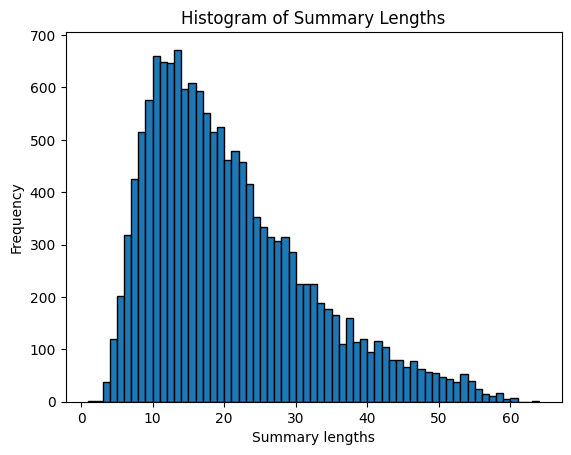

In [14]:
#Frequency distribution of the lengths of the summaries in the train dataset
plt.hist(df_train['summary_length'].apply(lambda x: x[0]), bins=range(min(df_train['summary_length'].apply(lambda x: x[0])), max(df_train['summary_length'].apply(lambda x: x[0])) + 1), edgecolor='black')
plt.title("Histogram of Summary Lengths")
plt.xlabel("Summary lengths")
plt.ylabel("Frequency")
plt.show()

# Inference with Pre-Trained Models

In [15]:
#Selecting a few random examples to check the generated summaries of few pre-trained models against ground truth
random_inference_examples = test_ds.shuffle(seed=42)[:5]
random_inference_examples

,id,dialogue,summary
0,13716075,Claire: <file_photo>\r\nKim: Looks delicious.....,Both Claire and Linda are making curry for din...
1,13681165-1,Alyssa: Have you seen Fergie’s national anthem...,Derek and Alyssa make fun of Fergie's performa...
2,13612194,"Ann: Hi, is the laptop still available?\r\nJos...",Ann wants to buy Josh's laptop for $200. Josh ...
3,13819045,Matt: have you heard that Bon Jovi are coming ...,Matt and Tony want to go to the concert of Bon...
4,13814769,Anastasia: Our new school photos\r\nAnastasia:...,Anastasia sent her new school photos to Darrell.


In [16]:
#generating summaries for the above subset using bart-large-cnn
from transformers import pipeline
bart_large_summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
dialogues = random_inference_examples['dialogue']
summaries = random_inference_examples['summary']
bart_predicted_summaries = []
for dialogue in dialogues:
    bart_predicted_summaries.append(bart_large_summarizer(dialogue, max_length=35, min_length=10))

#infrence_df = pd.DataFrame({'true_summary':summaries, 'predicted_summary':predicted_summaries})
#infrence_df

2024-02-23 21:27:22.230623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 21:27:22.230731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 21:27:22.349809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [17]:
summaries

0    Both Claire and Linda are making curry for din...
1    Derek and Alyssa make fun of Fergie's performa...
2    Ann wants to buy Josh's laptop for $200. Josh ...
3    Matt and Tony want to go to the concert of Bon...
4     Anastasia sent her new school photos to Darrell.
Name: summary, dtype: object

In [18]:
bart_predicted_summaries

[[{'summary_text': "Linda: No way... Look what I'm cooking right now. Claire: hahahaha   Kim: Curry dream team."}],
 [{'summary_text': 'Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job. Derek: I can fart bright stripes and bright stars'}],
 [{'summary_text': 'Ann: Hi, is the laptop still available? Josh: Yes it is. Ann: I can pay 200 dollars. Josh: The price is 250 and it'}],
 [{'summary_text': 'Bon Jovi are coming to Poland next July. The tickets are expected to cost around £250.'}],
 [{'summary_text': 'Anastasia: "School photos always suck. They take them so fast and carelessly" "I actually find it kind of funny, it\'s fine,"'}]]

In [19]:
#generating summaries for the above subset using t5-large
t5_large_summarizer = pipeline("summarization", model="google-t5/t5-large")
t5_predicted_summaries = []
for dialogue in dialogues:
    t5_predicted_summaries.append(t5_large_summarizer(dialogue, max_length=35, min_length=10))


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [20]:
t5_predicted_summaries

[[{'summary_text': "Linda: 'look what i'm cooking right now: curry dream team'"}],
 [{'summary_text': 'Derek: i can fart bright stripes and bright stars better then she sings .'}],
 [{'summary_text': "the price is 250 dollars and it's non-negotiable . do you have a bag and a small usb mouse?"}],
 [{'summary_text': 'Matt: have you heard that bon jovi are coming to Poland? Phil: no way! where, when? Warsaw, next July . tickets start from'}],
 [{'summary_text': 'school photos always suck Anastasia: they take them so fast and carelessly darrell: luckily no one really has to look at your school ID'}]]

In [21]:
#generating summaries for the above subset using pegasus-large
pegasus_large_summarizer = pipeline("summarization", model="google/pegasus-large")
pegasus_predicted_summaries = []
for dialogue in dialogues:
    pegasus_predicted_summaries.append(pegasus_large_summarizer(dialogue, max_length=35, min_length=10))


config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [22]:
pegasus_predicted_summaries

[[{'summary_text': "Look what I'm cooking right now: Linda: file_photo> Claire: hahahaha Kim: Curry dream team Claire: Enjoy your dinner :"}],
 [{'summary_text': 'Derek: This is not normal. Derek: I can fart bright stripes and bright stars better then she sings.'}],
 [{'summary_text': "Josh: Yes it is Ann: I can pay 200 dollars Josh: The price is 250 and it's non-negotiable Ann: Do you have a bag for"}],
 [{'summary_text': "Phil: they're huge, I guess tix can cost a bomb Matt: I read the cheapest ones start from pln 250 Phil: not too bad,"}],
 [{'summary_text': 'Anastasia: Yeah Anastasia: School photos always suck Anastasia: They take them so fast and carelessly Darrell: They would only really take group photos of us in middle'}]]

In [23]:
#a dataframe to compare all the generated summaries against each other and the gound truth
infrence_df = pd.DataFrame({'true_summary':summaries, 'bart_predicted_summary':[predicted_summary[0]['summary_text'] for predicted_summary in bart_predicted_summaries],
                           't5_predicted_summary':[predicted_summary[0]['summary_text'] for predicted_summary in t5_predicted_summaries],
                           'pegasus_predicted_summary':[predicted_summary[0]['summary_text'] for predicted_summary in pegasus_predicted_summaries]})
infrence_df

,true_summary,bart_predicted_summary,t5_predicted_summary,pegasus_predicted_summary
0,Both Claire and Linda are making curry for din...,Linda: No way... Look what I'm cooking right n...,Linda: 'look what i'm cooking right now: curry...,Look what I'm cooking right now: Linda: file_p...
1,Derek and Alyssa make fun of Fergie's performa...,Alyssa: Have you seen Fergie’s national anthem...,Derek: i can fart bright stripes and bright st...,Derek: This is not normal. Derek: I can fart b...
2,Ann wants to buy Josh's laptop for $200. Josh ...,"Ann: Hi, is the laptop still available? Josh: ...",the price is 250 dollars and it's non-negotiab...,Josh: Yes it is Ann: I can pay 200 dollars Jos...
3,Matt and Tony want to go to the concert of Bon...,Bon Jovi are coming to Poland next July. The t...,Matt: have you heard that bon jovi are coming ...,"Phil: they're huge, I guess tix can cost a bom..."
4,Anastasia sent her new school photos to Darrell.,"Anastasia: ""School photos always suck. They ta...",school photos always suck Anastasia: they take...,Anastasia: Yeah Anastasia: School photos alway...


The summaries generated by these pretrained models are not coherent at all, neither do they capture the main points of the conversation. Since these models were not pre-trained on conversational type of data they dont seem to infer summaries from the conversations. They were pretrained on article style data and hence they perform poor. Once we fine-tune them, i hypothesize that they will perform well, because they will learn the semantics of conversation style text, and since they are already good at summarization , with the learnt semantics of conversation style text they will be good at summarizing this dataset

# Fine-Tuning

In [2]:
#importing necessary libraries and initializing the model and tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model_name = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_name, device = device)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)


2024-02-23 21:51:31.816800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 21:51:31.816900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 21:51:31.945664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
#since i converted dataset into dataframe, im loading it again
dataset = load_dataset('samsum')

In [9]:
#Tokenizing the dialogs and summaries
def tokenize(batch):
    inputs = tokenizer(batch['dialogue'], truncation = True)
    outputs = tokenizer(batch['summary'], truncation = True)
    inputs['labels'] = outputs['input_ids']
    return inputs
    

In [10]:
tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer, model = model_name)

In [12]:

!pip install evaluate
!pip install rouge_score

#Ignore this code
"""import evaluate

rouge = evaluate.load("rouge")

import numpy as np

def generate_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]
    
    
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    batched_predictions = list(generate_batches(predictions,16))
    batched_labels = list(generate(batches(labels,16)))
    
    for pred_batch, label_batch in zip(batched_predictions, batched_labels):
        decoded_preds = tokenizer(pred_batch, truncation=True, return_tensors="pt")
        decoded_labels = tokenizer(label_batch, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        
        rouge.add_batch(predictions=decoded_preds, references = decoded_labels)
        
        
    
    #decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    #labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    #decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    

    result = rouge.compute()

    

    return result

"""

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6a3268c00ffd9cb9342859a37e331447cd4e3216de5a54c4423f562847ae6e42
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [13]:
#Defining the training arguments and the trainer

finetuned_model_name = f'{model_name}-finetuned-samsum'




training_args = Seq2SeqTrainingArguments(
    output_dir=finetuned_model_name,
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    fp16=True
)

#Tried including compute_metrics argument but ran into cuda out of memory issues (while performing validation) no matter how many times i tried to 
#incorporate batching in the previous cell's compute_metrics method. Couldnot fix it soremoved that argument.
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)



In [14]:
#Validation loss keeps increasing but training loss keeps decreasing. However since this is a summarization task where outputs 
#can be different and still be valid summarization, I ignored the increasing loss and went with the fully trained model after 
#4 epochs instead of the model with lowest validation loss
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
500,1.351100,1.402589
1000,1.248300,1.378335
1500,1.023600,1.390303
2000,0.977400,1.390275
2500,0.842300,1.411225
3000,0.789500,1.460153
3500,0.725100,1.461311


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=3680, training_loss=0.9807096191074537, metrics={'train_runtime': 7038.8626, 'train_samples_per_second': 8.372, 'train_steps_per_second': 0.523, 'total_flos': 1.975765349724979e+16, 'train_loss': 0.9807096191074537, 'epoch': 4.0})

In [26]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)  # Suppress warnings, only show errors


Computing Rouge Scores

In [27]:
!pip install tqdm
from tqdm import tqdm
from transformers import pipeline
import evaluate
rouge = evaluate.load('rouge')
summarizer = pipeline('summarization', model = 'facebook/bart-large-cnn', device = device)
batch_size = 4
for i in tqdm(range(0,len(dataset['validation']), batch_size)):
    batch = dataset['validation'][i:i+batch_size]
    dialogues = batch['dialogue']
    summaries = batch['summary']
    outputs = summarizer(dialogues, truncation=True)
    generated_summaries = [output['summary_text'] for output in outputs]
    rouge.add_batch(predictions=generated_summaries, references=summaries)
rouge.compute()

100%|██████████| 205/205 [10:28<00:00,  3.07s/it]


{'rouge1': 0.31166959672481687,
 'rouge2': 0.11196078336761939,
 'rougeL': 0.23400377153935928,
 'rougeLsum': 0.23384475898338658}

In [30]:
from torch.nn.utils.rnn import pad_sequence
batch_size = 4
rouge = evaluate.load('rouge')
for i in tqdm(range(0,len(tokenized_dataset['validation']), batch_size)):
    batch = tokenized_dataset['validation'][i:i+batch_size]
    input_ids = pad_sequence([torch.tensor(seq) for seq in batch['input_ids']], batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    attention_mask = pad_sequence([torch.tensor(seq) for seq in batch['attention_mask']], batch_first=True, padding_value=0).to(device)
    summaries = batch['summary']
    summary_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=60, num_beams=4, early_stopping=True)
    generated_summaries = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in summary_ids]
    rouge.add_batch(predictions=generated_summaries,references=summaries)
rouge.compute()

100%|██████████| 205/205 [05:22<00:00,  1.57s/it]


{'rouge1': 0.40457379789762976,
 'rouge2': 0.20108760733269715,
 'rougeL': 0.3090352768635158,
 'rougeLsum': 0.30918336397033125}

# Evaluation and Analysis

In [31]:
#Quantative analysis of test set using rouge scores
for i in tqdm(range(0,len(tokenized_dataset['test']), batch_size)):
    batch = tokenized_dataset['test'][i:i+batch_size]
    dialogues = batch['dialogue']
    summaries = batch['summary']
    outputs = summarizer(dialogues, truncation=True)
    generated_summaries = [output['summary_text'] for output in outputs]
    rouge.add_batch(predictions=generated_summaries, references=summaries)
pre_train_rouge_scores = rouge.compute()
for i in tqdm(range(0,len(tokenized_dataset['test']), batch_size)):
    batch = tokenized_dataset['test'][i:i+batch_size]
    input_ids = pad_sequence([torch.tensor(seq) for seq in batch['input_ids']], batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    attention_mask = pad_sequence([torch.tensor(seq) for seq in batch['attention_mask']], batch_first=True, padding_value=0).to(device)
    summaries = batch['summary']
    summary_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=60, num_beams=4, early_stopping=True)
    generated_summaries = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in summary_ids]
    rouge.add_batch(predictions=generated_summaries,references=summaries)
finetuned_rouge_scores = rouge.compute()

100%|██████████| 205/205 [05:23<00:00,  1.58s/it]


In [32]:
#Comparing the rouge scores of pretrained and finetuned model on the test set
import pandas as pd


df_rouge_scores = pd.DataFrame({
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum'],
    'Pretrained': [pre_train_rouge_scores['rouge1'], pre_train_rouge_scores['rouge2'], pre_train_rouge_scores['rougeL'], pre_train_rouge_scores['rougeLsum']],
    'Fine-tuned': [finetuned_rouge_scores['rouge1'], finetuned_rouge_scores['rouge2'], finetuned_rouge_scores['rougeL'], finetuned_rouge_scores['rougeLsum']]
})

df_rouge_scores


,Metric,Pretrained,Fine-tuned
0,ROUGE-1,0.304781,0.392530
1,ROUGE-2,0.103279,0.185561
2,ROUGE-L,0.225566,0.298589
3,ROUGE-Lsum,0.225632,0.298817


Rouge scores have deifintely improved

In [46]:
#Qualitative analysis of the models by generating summaries on randomly selected samples
random_inference_examples = tokenized_dataset['test'].shuffle(seed=42)[:5]
pretrained_summaries = summarizer(random_inference_examples['dialogue'], truncation=True)
pretrained_summaries = [summary['summary_text'] for summary in pretrained_summaries]
input_ids = pad_sequence([torch.tensor(seq) for seq in random_inference_examples['input_ids']], batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
attention_mask = pad_sequence([torch.tensor(seq) for seq in random_inference_examples['attention_mask']], batch_first=True, padding_value=0).to(device)
summary_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=60, num_beams=4, early_stopping=True)
finetuned_summaries = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in summary_ids]


In [54]:
df = pd.DataFrame({
    'Dialogue': random_inference_examples['dialogue'],
    'Summary': random_inference_examples['summary'],
    'Pretrained Summaries': pretrained_summaries,
    'Finetuned Summaries': finetuned_summaries
    
})
pd.set_option('display.max_colwidth', None)
df

,Dialogue,Summary,Pretrained Summaries,Finetuned Summaries
0,Claire: <file_photo>\r\nKim: Looks delicious...\r\nLinda: No way... Look what I'm cooking right now:\r\nLinda: <file_photo>\r\nClaire: hahahaha \r\nKim: Curry dream team\r\nClaire: Enjoy your dinner :*,Both Claire and Linda are making curry for dinner.,Linda: No way... Look what I'm cooking right now. Claire: hahahaha Kim: Curry dream team. Linda: What's for dinner? Claire: Curry. Kim: Looks delicious... Linda: Curry! Claire: Enjoy your dinner :*,"Claire, Kim and Linda are having a curry for dinner. Linda is cooking right now. She sends Claire a photo of it. Claire and Kim think it looks delicious. They are the Curry Dream Team. . ""Enjoy your dinner""."
1,Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job.\r\nDerek: This is not normal. I saw it last week…\r\nAlyssa: What do you think about it?\r\nDerek: I can fart bright stripes and bright stars better then she sings.\r\nAlyssa: The best part is that she acts like she nailed it. But at least it's funny in a good way.\r\nDerek: It is 😂,Derek and Alyssa make fun of Fergie's performance of the national anthem.,"Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job. Derek: I can fart bright stripes and bright stars better then she sings. But at least it's funny in a good way, Alyssa says. The best part is that she acts like she nailed it, Derek adds.",Derek doesn't like Fergie's national anthem. Alyssa likes it because she acts like she nailed it and it's funny in a good way. Derek thinks he can sing the anthem better than Fergia. Derek saw the video last week.
2,"Ann: Hi, is the laptop still available?\r\nJosh: Yes it is\r\nAnn: I can pay 200 dollars\r\nJosh: The price is 250 and it's non-negotiable\r\nAnn: Do you have a bag for it? Some other accessories?\r\nJosh: I have a bag and a small usb mouse\r\nAnn: Sounds good, I'll take it, where can I pick it up?",Ann wants to buy Josh's laptop for $200. Josh doesn't want to negotiate the price. Ann will take it for $250 with accessories.,"Ann: Hi, is the laptop still available? Josh: Yes it is. Ann: I can pay 200 dollars for it. Josh: The price is 250 and it's non-negotiable.Ann: Sounds good, I'll take it, where can I pick it up?","Ann will buy a laptop from Josh for 250 dollars. Josh has a bag and a small USB mouse with which to transport the laptop. Ann will pick it up in a few days. ""It's non-negotiable. It's in good condition""."
3,"Matt: have you heard that Bon Jovi are coming to Poland?\r\nPhil: No way!\r\nPhil: where, when?\r\nMatt: Warsaw, next July\r\nTony: would you like to go?\r\nMatt: Sure!\r\nPhil: how much are the tickets? Very expensive?\r\nPhil: they're huge, I guess tix can cost a bomb\r\nMatt: I read the cheapest ones start from pln 250\r\nPhil: not too bad, for Bon Jovi\r\nMatt: Yep!\r\nTony: maybe I will go too\r\nTony: Would you like to get the tix soon?\r\nMatt: Yes\r\nMatt: The sooner, the better\r\nTony: Right, they may be sold out pretty soon\r\nMatt: How about you, Phil?\r\nMatt: would you like to go too?\r\nPhil: Will think about it\r\nPhil: I liked them a lot when I was a kid\r\nPhil: It would be great to see them live\r\nMatt: I guess so!\r\nMatt: Think about it and let me know soon, ok?\r\nPhil: Sure",Matt and Tony want to go to the concert of Bon Jovi next July in Poland and are planning to buy the tickets that cost 250 PLN before they’re sold out. Phil will think about it and let them know.,"Bon Jovi are coming to Poland, next July. Tickets for the Warsaw show start from pln 250. The tickets are expected to be sold out pretty soon. The concert will take place at the Narodowy Arena in Warsaw. The show will be the first Bon Jovi concert to be held in Poland.","Bon Jovi are coming to Warsaw next July. Tickets start from PLN 250. Matt, Phil and Tony will try to get the tickets soon. They will let Phil know if he wants to go with them. Phil liked Bon Jovi when he was a kid."
4,"Anastasia: Our new sch

The new finetuned model generated summaries that are much better than the ones generated by the pre-trained model. The summaries are fluent, coherent, and capture some of the key points while also including points that are what the dialogs actually meant. The pretrained models' summaries seemed less like a summary, more like a compressed/cut-short conversation. Whereas the finetuned model's summaries seem like actual summeries. The summaries generated by the finetuned model are a bit large. Maybe I should have set the max_length to around 30 instead of leaving it so high. But the generated summaries are acceptable, they are not good but they are acceptable. Maybe if we had more data, or if i had run it for more epochs, it would have been better.

In [36]:
torch.cuda.empty_cache()

# Report


**Dataset Preparation:** I 